# Anatomical receptive field (RF) analysis and plot

The connectomics data in this study comes from the right optic lobe of the full adult female fly brain (FAFB) electron microscopic dataset. Each neuron type was first visually inspected to make sure that all neuronal projections were intact via FlyWire neuroglancer (backbone proofreading). Then, we obtained their neuronal connections via a custom-written code in Python 3.9 using the fafbseg python package. To process the data further, we utilized the pandas (https://pandas.pydata.org/), numpy (https://numpy.org/), scipy (https://scipy.org/), Navis, and matplotlib (https://matplotlib.org/) packages for analysis and data visualization.

In [1]:
# Importing packages
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull
from fafbseg import flywire
from helper import replace_outliers_with_nan, combine_xyz, match_all_pre_to_single_post, calculate_spatial_span, add_mean_median_lines
import navis

C:\Users\sebas\anaconda3\envs\EM\lib\site-packages\blessed\terminal.py:186: UserWarning: Failed to setupterm(kind='xterm-color'): Could not find terminal xterm-color
  warnings.warn(msg)


## Presynaptic partner visualization

For a total of 700 Tm9s (medulla columns), we identified presynaptic partners as described in Cornean,Molina-Obando, et al., 2024. In short, we identified approximately 80% of all inputs by tracing and annotating presynaptic segments with at least 3 synapses. We selected consistent partners based on their presence in at least 5% of all analyzed columns. The neurotransmitter identity for these presynaptic partner types was verified through electron microscopy predictions (Eckstein, N. et al., 2023), complemented by an RNA seq dataset (Davis et al., 2020)

In [2]:
# Loading data
PC_disc = 'D'
dataPath = f'{PC_disc}:\FlyWire-Data\Processed-data'
fig_save_path = os.path.join(dataPath,"Figures")
save_figures = True

current_data = 'Tm9_700_R_20231113.xlsx'

filePath =  os.path.join(dataPath,current_data)
_sheet_name = 'Relative_counts'

data_df = pd.read_excel(filePath, sheet_name=_sheet_name,index_col = 0)
display(data_df.head())
number_of_columns = len(data_df)
pre_partners_ls = data_df.columns.tolist()
print(f'Total number of columns: {number_of_columns}')
print(f'All presynatic partners: \n {pre_partners_ls}')

,Tm16,Mi4,CT1,L3,Dm12,C3,Tm20,Tm1,ML1,PS125,...,Dm14,Dm8,L1,TmY25,TmY27,TmY22,Dm2,Dm1,TmY18,MeMe
instance_post,,,,,,,,,,,,,,,,,,,,,
Tm9::R100:D,10.82,17.12,8.11,22.52,NaN,3.60,3.60,2.70,4.50,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tm9::R101:V,NaN,21.70,12.26,26.42,2.83,3.77,2.83,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tm9::R102:V,5.31,8.85,13.27,30.09,2.65,7.08,6.19,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tm9::R103:V,NaN,9.09,11.11,29.29,NaN,NaN,4.04,NaN,NaN,4.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tm9::R104:V,6.34,7.75,9.86,23.94,2.11,5.63,NaN,2.11,2.82,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Total number of columns: 700
All presynatic partners: 
 ['Tm16', 'Mi4', 'CT1', 'L3', 'Dm12', 'C3', 'Tm20', 'Tm1', 'ML1', 'PS125', 'L4', 'C2', 'OA-AL2b2', 'TmY17', 'pMP7', 'TmY15', 'Mi13', 'Tm2', 'TmY10', 'Dm10', 'Mi9', 'Y3', 'T2', 'Tm23', 'TmY14', 'Dm3', 'Mi10', 'TmY11', 'Dm4', 'Tm4', 'Mi14', 'T5a', 'Dm15', 'Mi1', 'Dm20', 'Tm1a', 'Mi8', 'T5', 'Dm13', 'L2', 'Dm9', 'LC14b', 'Tm9', 'Tm5', 'Pm1a', 'T5c', 'T2a', 'T5b', 'TmY3', 'Lawf1', 'Tm5b', 'glia', 'R8', 'MeTu_m_l', 'Mt-N.I.', 'TmY21', 'TmY26', 'Me-Lo-2-N.I.', 'TmY24', 'TmY28', 'T3', 'TmY23', 'Mi?', 'glia ', 'Dm14', 'Dm8', 'L1', 'TmY25', 'TmY27', 'TmY22', 'Dm2', 'Dm1', 'TmY18', 'MeMe']


In [3]:
# Applying a presence threshold based on NaN values
percetatge_prescence = 0.05
threshold = percetatge_prescence * len(data_df)

# Filter columns based on the threshold
filtered_data_df = data_df.dropna(thresh=threshold, axis=1)
filtered_pre_partners_ls = filtered_data_df.columns.tolist()
print(f'All presynatic partners: \n {filtered_pre_partners_ls}')

All presynatic partners: 
 ['Tm16', 'Mi4', 'CT1', 'L3', 'Dm12', 'C3', 'Tm20', 'Tm1', 'ML1', 'PS125', 'L4', 'C2', 'OA-AL2b2', 'TmY17', 'pMP7', 'TmY15', 'Mi13', 'Tm2', 'TmY10']


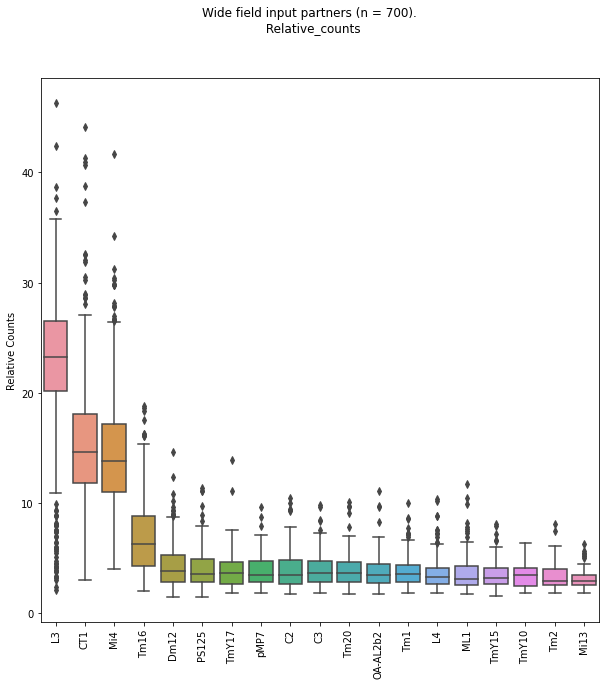

In [4]:
# Visualization
# Adjust subplot spacing and rotate x-axis labels
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)


major_inputs_data = filtered_data_df
#major_inputs_data = filtered_data_df[['L3', 'Mi4', 'CT1', 'Tm16', 'Dm12']]

sns.boxplot(data=major_inputs_data[major_inputs_data.mean().sort_values(ascending = False).index], ax=axs)
axs.set_ylabel('Relative Counts')
axs.set_xticklabels(axs.get_xticklabels(), rotation=90)  # Rotate x-axis labels   

fig.suptitle(f'Wide field input partners (n = {number_of_columns}). \n {_sheet_name}')
plt.show()

## Anatomical RF size analysis

For each Tm9, we identified each connected presynaptic neuron (e.g., Dm12) and calculated the area and column span. For each connecting pair, we initially determined the volume occupied by the given presynaptic neuron perpendicular to the Tm9 transmedullar axis of projection. To measure the area (um^2) covered by a presynaptic neuron, we extrapolated the volume into a single plane perpendicular to the Tm9 projection axis and measured it using a convex hull measurement. The Dm12 column span was calculated as the distance between the furthest two points of the volume normalized by the distance of one single column span (averaging 11.2 um in diameter).
 
To obtain both the Tm9 projection axis and the plane perpendicular to it for the mentioned procedure, we used the XYZ coordinates for all presynaptic sites of a given Tm9. Since Tm9 is a unicolumnar and transmedullar neuron perpendicular to the medulla surface, the eigenvector of the first PCA component aligns with that axis, and the eigenvectors for the second and third PCA components form the perpendicular plane. All presynaptic neuron XYZ sites were projected to that 2D plane to calculate the covered area for each presynaptic partner.

In [5]:
#For analysis purposes
min_desired_count = 3 # minimun desired number of contacts between pre and post neurons to be considered
single_column_diameter = 11.2 # in um (measured in FlyWire)
single_column_area = 100 # in um^2 (Assumed column as circle)

#For plotting purposes
PC_disc = 'D'
dataPath = f'{PC_disc}:\Connectomics-Data\FlyWire\Processed-data'
fig_save_path = os.path.join(dataPath,"Figures")
save_figures = True

#General style
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 8}
axes = {'labelsize': 12, 'titlesize': 12}
ticks = {'labelsize': 10}
legend = {'fontsize': 8}
plt.rc('font', **font)
plt.rc('axes', **axes)
plt.rc('xtick', **ticks)
plt.rc('ytick', **ticks)

#Saving text for pdfs in a proper way
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# For plotting purposes

hemisphere = 'R' # 'R', 'L'
neuropile_mesh = 'ME_L'
mesh_azim = 16# -18 for ME_R, 16 for ME_L
mesh_elev = -50 # -148 for ME_R, -50 for ME_L
cm = 1/2.54  # centimeters in inches

In [6]:
#############################################################################################
########## Matching all presynaptic cell ids connecting to each postsynaptic cell ###########


## Loading information  from excel files
PC_disc = 'D'
dataPath = f'{PC_disc}:\FlyWire-Data\database'
date = '20230912'
pre_neuron_type = 'Dm12'
post_neuron_type = 'Tm9'
fileName_post = f'{post_neuron_type} proofreadings.xlsx'
filePath_post = os.path.join(dataPath,fileName_post)
fileName_pre = f'{pre_neuron_type} proofreadings.xlsx'
filePath_pre = os.path.join(dataPath,fileName_pre)

#Loading file as DataFrame
post_df = pd.read_excel(filePath_post)
pre_df = pd.read_excel(filePath_pre)

## Filtering data
# Selecting the R optic lobe IDs
R_pre_df = pre_df[pre_df['hemisphere'] == hemisphere].copy()
R_post_df = post_df[post_df['hemisphere'] == hemisphere].copy()
# Selecting the backbone proofread IDs
R_post_df = R_post_df[R_post_df['backbone proofread (Y/N)'] == 'Y'].copy()
R_pre_df = R_pre_df[R_pre_df['backbone proofread (Y/N)'] == 'Y'].copy()
# Selecting presynaptic cells ids
pre_ids = R_pre_df['Updated_seg_id'].tolist()

# Quick updates
# Updating presynaptic neurons if they are not up-to-date
if not np.unique(flywire.is_latest_root(pre_ids))[0]: #if not up-to-date
    print('Consider updating your ids in the original pre-neuron data set:')
    pre_ids_update_df = flywire.update_ids(pre_ids, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
    up_to_date_pre_ids = pre_ids_update_df['new_id'].tolist()
    display(pre_ids_update_df[pre_ids_update_df['changed'] == True])
else:
    up_to_date_pre_ids = [int(x) for x in pre_ids]
    print('All pre ids were up to date')
    

    ## Getting postsynaptic side ID
post_ids = R_post_df['Updated_seg_id'].tolist()

## Updating postsynaptic neurons if they are not up-to-date
if not np.unique(flywire.is_latest_root(post_ids))[0]: # if not up-to-date
    print('Consider updating your ids in the original post neuron data set:')
    #Updating the IDs via Fafbseg
    post_ids_update_df = flywire.update_ids(post_ids, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
    up_to_date_post_ids = post_ids_update_df['new_id']
    display(post_ids_update_df[post_ids_update_df['confidence'] < 1])
else:
    up_to_date_post_ids = [int(x) for x in post_ids]
    print('All post ids were up to date')
    

## Doing the pre to post match
pre_post_counts, post_inputs = match_all_pre_to_single_post(up_to_date_post_ids, up_to_date_pre_ids, neuropile_mesh) 

Consider updating your ids in the original pre-neuron data set:


Updating:   0%|          | 0/41 [00:00<?, ?it/s]

,old_id,new_id,confidence,changed
2,720575940627971709,720575940621626560,1.00,True
10,720575940631099708,720575940633977645,1.00,True
12,720575940629488646,720575940615956118,1.00,True
15,720575940622687220,720575940630032144,1.00,True
20,720575940606569318,720575940628822088,1.00,True
22,720575940624885685,720575940632539407,0.99,True
24,720575940621711598,720575940623599740,1.00,True
38,720575940606785382,720575940628822088,1.00,True


Consider updating your ids in the original post neuron data set:


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

,old_id,new_id,confidence,changed
416,720575940616417653,720575940608436914,0.98,True


Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

In [7]:
#############################################################################################
## Analysis of spatial span of preynaptic inputs to single, unicolumnar, postsynaptic cells ##

# Synaptic counts filter
pre_post_counts = pre_post_counts[pre_post_counts['pre_syn_count']>=min_desired_count].copy()
print('Pre-post match example after min syn fiter:')
display(pre_post_counts.head())

## Geeting information for all pre cells 
pre_ls = pre_post_counts['pre_pt_root_id'].tolist() # all postsynaptic neurons

# Fetch the inputs from presynaptic cells
#TODO change "pre_inputs" to "pre_connectivity" (which includes inputs and outputs)
pre_inputs = flywire.synapses.fetch_synapses(pre_ls, pre=True, post=True, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")

# Filtering: keeping only synapses in the medulla
pre_inputs = pre_inputs[pre_inputs['neuropil'] == neuropile_mesh].copy()
len(pre_inputs)

#Combining pre- and postsynpases XYZ values in single columns
combine_xyz(pre_inputs) # Function that does the operation

## Quantificatino of the spatial span
spatial_span_df, individual_spatial_span_df = calculate_spatial_span(up_to_date_post_ids, up_to_date_pre_ids, post_ids_update_df, R_post_df, post_inputs, pre_post_counts, pre_inputs, single_column_area, single_column_diameter)

Pre-post match example after min syn fiter:


,post_pt_root_id,pre_pt_root_id,pre_syn_count
0,720575940600084489,720575940633977645,8
1,720575940602880736,720575940612534641,3
6,720575940604810208,720575940628360469,3
7,720575940605034161,720575940628360469,4
8,720575940605480369,720575940618698781,4


Fetching synapses:   0%|          | 0/6 [00:00<?, ?it/s]

Calculating spatial span


### Plotting a single case (for visualization and methods)

In [8]:
# Choosing a single presynaptic neuron

_data = individual_spatial_span_df
single_data = _data[(_data['Area'] > 999) & (_data['Area'] < 1000)].copy() 
single_data = single_data.iloc[0]
display(single_data)


Volume                                                6872225261973.319336
Area                                                            999.308348
Diameter                                                         24.827099
Diameter_projected                                               14.567143
Hull                     <scipy.spatial.qhull.ConvexHull object at 0x00...
Pre_count                                                                1
Pre_xyz                  [[792588.0, 314112.0, 143560.0], [791300.0, 31...
Pre_center               [799240.2438452521, 313897.7162954279, 149820....
Post_xyz                 [[802992.0, 310280.0, 145040.0], [800568.0, 30...
pre_projected_points     [[7436.328089199937, 3699.213460221576], [6134...
Area_zscore                                                      -0.193374
Num_pre_sites                                                          853
Num_columns                                                             10
Column_span              

meta NOT subset; don't know how to subset; dropped


FIGURE: 2D projection of single cell saved


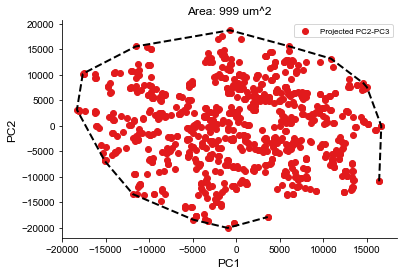

In [9]:
# Create a 2D scatter plot for PCA-based projection

color_rgb = (226 / 255, 26 / 255, 28 / 255)  # Red in RGB 


projected_points = single_data.loc['pre_projected_points']

#Calculate area
# Calculate the convex hull of the projected points
hull = ConvexHull(projected_points)

# Calculate the area of the convex hull
area = hull.volume  # Area is calculated as volume in 2D
area_um2 = area / 10**6

# Create a scatter plot of the PC1 and PC2 components
plt.scatter(projected_points[:, 0], projected_points[:, 1], marker='o', label='Projected PC2-PC3', color=color_rgb)

plt.plot(projected_points[hull.vertices,0], projected_points[hull.vertices,1], 'k--', lw=2)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'Area: {round(area_um2)} um^2')

# Access the current Axes instance
ax = plt.gca()

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Show the plot
plt.legend()

if save_figures:
    plt.savefig(os.path.join(fig_save_path, f'{pre_neuron_type}-2D-projection.pdf'))
    print('FIGURE: 2D projection of single cell saved')
    plt.show()

FIGURE: All neurons spatial span saved


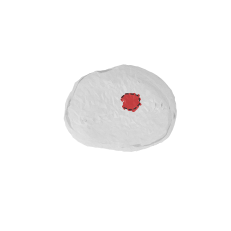

In [10]:
# Create a 3D scatter plot medulla top view

row_index = 720575940641730549 # For this particlar cell
color_rgb = (226 / 255, 26 / 255, 28 / 255)  # Red in RGB 


pre_coords = projected_points = single_data.loc['Pre_xyz']
# Brief visualization for volumes
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.plot(pre_coords[:,0], pre_coords[:,1], pre_coords[:,2],'o',markersize=1, color=color_rgb)
ax.plot(pre_coords[hull.vertices,0], pre_coords[hull.vertices,1], pre_coords[hull.vertices,2], 'k--', lw=1)

OL_R = flywire.get_neuropil_volumes([neuropile_mesh]) 
navis.plot2d([OL_R], method='3d_complex', ax=ax)

ax.azim = mesh_azim
ax.elev = mesh_elev

if save_figures:    
    figure_title = f'\Mesh-3D-projection-{pre_neuron_type}.pdf'
    fig.savefig(fig_save_path + figure_title)
    print('FIGURE: All neurons spatial span saved')

FIGURE: All neurons spatial span saved


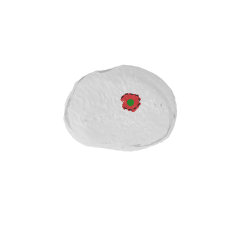

In [11]:
# Adding a single column of reference

# Extract coordinates
pre_coords = projected_points = single_data.loc['Pre_xyz']

# Calculate centroid
centroid = np.mean(pre_coords, axis=0)

# Area of the assumed column
single_column_area = 100  # in um^2

# Calculate radius based on area
radius = np.sqrt(single_column_area / np.pi)

# Brief visualization for volumes
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plot red dots
ax.plot(pre_coords[:, 0], pre_coords[:, 1], pre_coords[:, 2], 'o', markersize=1, color=color_rgb)

# Plot convex hull
ax.plot(pre_coords[hull.vertices, 0], pre_coords[hull.vertices, 1], pre_coords[hull.vertices, 2], 'k--', lw=1)

# Plot neuropil volumes
OL_R = flywire.get_neuropil_volumes([neuropile_mesh])
navis.plot2d([OL_R], method='3d_complex', ax=ax)

# Plot green circle at centroid
ax.plot(centroid[0], centroid[1], centroid[2], 'o', markersize=  radius, color='green')

# Move the green circle to the surface based on azimuth and elevation
theta = np.radians(ax.azim)
phi = np.radians(ax.elev)

x_surface = radius * np.sin(phi) * np.cos(theta) + centroid[0]
y_surface = radius * np.sin(phi) * np.sin(theta) + centroid[1]
z_surface = radius * np.cos(phi) + centroid[2]

ax.plot(x_surface, y_surface, z_surface, 'o', markersize= radius, color='green')


ax.azim = mesh_azim
ax.elev = mesh_elev

if save_figures:    
    figure_title = f'\Mesh-3D-projection-{pre_neuron_type}-and-single column.pdf'
    fig.savefig(fig_save_path + figure_title)
    print('FIGURE: All neurons spatial span saved')

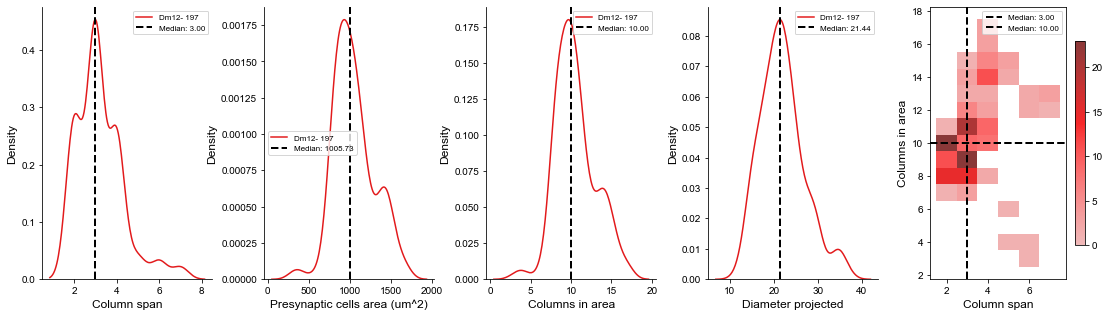

meta NOT subset; don't know how to subset; dropped


FIGURE: Spatial span saved


In [13]:
### Plotting histograms in same subplots:
_data = individual_spatial_span_df

kde_only = True
filter_ouliers = False

# Create a single figure and axis for all subplots
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(40*cm, 12*cm))
fig.tight_layout(pad=3)

# Define colors 
color_rgb = (226 / 255, 26 / 255, 28 / 255)  # Red in RGB 
       

# Outlier filter
if filter_ouliers:
    _data = replace_outliers_with_nan(_data, multiplier=1.5)

# Plot histograms and/or KDE in the respective subplots
histograms = [_data['Column_span'], _data['Area'], _data['Num_columns'], _data['Diameter_projected']]
subplot_labels = ['Column span', 'Presynaptic cells area (um^2)', 'Columns in area', 'Diameter projected']
histograms_bin_width = [None, None, None, None]

# Reset the index to avoid reindexing issues
for i, data in enumerate(histograms):
    data = data.reset_index(drop=True)

    if kde_only:
        sns.kdeplot(data, ax=axs[i], label=f'{pre_neuron_type}- {len(data)}', color=color_rgb)
        axs[i].set_ylabel('Density')
    else:
        sns.histplot(data, binwidth=histograms_bin_width[i], ax=axs[i], label=f'{pre_neuron_type} - {len(data)}', color=color_rgb, alpha=0.075, 
                         kde=True, element="step", fill=True, stat="count")
        axs[i].set_ylabel('Count')

    axs[i].set_xlabel(subplot_labels[i])
        
    # Add mean and median lines
    add_mean_median_lines(data, axs[i], 'red', 'k')
        
    #Remove spines
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)

# Last subplot
_data_reset_index = _data.reset_index()
sns.histplot(
_data_reset_index, x='Column_span', y='Num_columns',
bins=30, discrete=(True, True), log_scale=(False, False), color=color_rgb,
cbar=True, cbar_kws=dict(shrink=.75), ax=axs[4], label=f'{pre_neuron_type} - {len(data)}')
axs[4].set_xlabel('Column span')
axs[4].set_ylabel('Columns in area')

    
# Add mean and median lines for x- and y-axis
add_mean_median_lines(_data_reset_index['Column_span'], axs[4], 'red', 'k')
add_mean_median_lines(_data_reset_index['Num_columns'], axs[4], 'red', 'k', vertical=False)

# Add legends to the subplots
for i in range(5):
    axs[i].legend()

# Show the figure
plt.show()

if save_figures:    
    figure_title = f'\{pre_neuron_type}-neuron-spatial-span-quantification.pdf'
    fig.savefig(fig_save_path+figure_title)
    print('FIGURE: Spatial span saved')

### Anatomica RF analysis for many presynaptic partners

In [14]:
########## Looping across all presynaptic cell types


#############################################################################################
########## Matching all presynaptic cell ids connecting to each postsynaptic cell ###########

pre_neuron_type_ls = ['L3','Mi4','L4','Tm16','Dm12','C2','C3','Mi13','Tm1','Tm20','TmY10','TmY15','TmY17'] 

spatial_span_df_dict = {}
individual_spatial_span_df_dict = {}

for pre_neuron_type in pre_neuron_type_ls:
    print(f'Analyzing {pre_neuron_type}')

    ## Loading information  from excel files
    PC_disc = 'D'
    dataPath = f'{PC_disc}:\Connectomics-Data\FlyWire\Excels\drive-data-sets\database'
    date = '20230912'
    post_neuron_type = 'Tm9'
    fileName_post = f'{post_neuron_type} proofreadings.xlsx'
    filePath_post = os.path.join(dataPath,fileName_post)
    fileName_pre = f'{pre_neuron_type} proofreadings.xlsx'
    filePath_pre = os.path.join(dataPath,fileName_pre)

    #Loading file as DataFrame
    post_df = pd.read_excel(filePath_post)
    pre_df = pd.read_excel(filePath_pre)

    ## Filtering data
    # Selecting the R optic lobe IDs
    R_pre_df = pre_df[pre_df['hemisphere'] == hemisphere].copy()
    R_post_df = post_df[post_df['hemisphere'] == hemisphere].copy()
    # Selecting the backbone proofread IDs
    R_post_df = R_post_df[R_post_df['backbone proofread (Y/N)'] == 'Y'].copy()
    R_pre_df = R_pre_df[R_pre_df['backbone proofread (Y/N)'] == 'Y'].copy()
    # Selecting presynaptic cells ids
    pre_ids = R_pre_df['Updated_seg_id'].tolist()
    print(f'Number of neurons: {len( pre_ids)}')

    # Quick updates
    # Updating presynaptic neurons if they are not up-to-date
    if not np.unique(flywire.is_latest_root(pre_ids))[0]: #if not up-to-date
        print('Consider updating your ids in the original pre-neuron data set')
        pre_ids_update_df = flywire.update_ids(pre_ids, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
        up_to_date_pre_ids = pre_ids_update_df['new_id'].tolist()
    else:
        up_to_date_pre_ids = [int(x) for x in pre_ids]
        print('All pre ids were up to date')


        ## Getting postsynaptic side ID
    post_ids = R_post_df['Updated_seg_id'].tolist()

    ## Updating postsynaptic neurons if they are not up-to-date
    if not np.unique(flywire.is_latest_root(post_ids))[0]: # if not up-to-date
        print('Consider updating your ids in the original post neuron data set')
        #Updating the IDs via Fafbseg
        post_ids_update_df = flywire.update_ids(post_ids, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
        up_to_date_post_ids = post_ids_update_df['new_id']
    else:
        up_to_date_post_ids = [int(x) for x in post_ids]
        print('All post ids were up to date')


    ## Doing the pre to post match
    pre_post_counts, post_inputs = match_all_pre_to_single_post(up_to_date_post_ids, up_to_date_pre_ids, neuropile_mesh) 

    #############################################################################################
    ## Analysis f spatial span of preynaptic inputs to single, unicolumnar, postsynaptic cells ##

    # Synaptic counts filter
    pre_post_counts = pre_post_counts[pre_post_counts['pre_syn_count']>=min_desired_count].copy()

    ## Geeting information for all pre cells 
    pre_ls = pre_post_counts['pre_pt_root_id'].tolist() # all postsynaptic neurons

    # Fetch the inputs from presynaptic cells
    #TODO change "pre_inputs" to "pre_connectivity" (which includes inputs and outputs)
    pre_inputs = flywire.synapses.fetch_synapses(pre_ls, pre=True, post=True, attach=True, 
                                                 min_score=50, clean=True, transmitters=False, 
                                                 neuropils=True, batch_size=30, 
                                                 dataset='production', progress=True,mat= "live")

    # Filtering: keeping only synapses in the medulla
    pre_inputs = pre_inputs[pre_inputs['neuropil'] == neuropile_mesh].copy()
    len(pre_inputs)

    #Combining pre- and postsynpases XYZ values in single columns
    combine_xyz(pre_inputs) # Function that does the operation

    ## Quantificatino of the spatial span
    spatial_span_df, individual_spatial_span_df = calculate_spatial_span(up_to_date_post_ids, up_to_date_pre_ids, post_ids_update_df, R_post_df, post_inputs, pre_post_counts, pre_inputs, single_column_area, single_column_diameter)
    spatial_span_df_dict[pre_neuron_type] = spatial_span_df
    individual_spatial_span_df_dict[pre_neuron_type] = individual_spatial_span_df
    
print('Analysis done.')
    

Analyzing L3
Number of neurons: 645
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/645 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/18 [00:00<?, ?it/s]

Calculating spatial span
Analyzing Mi4
Number of neurons: 723
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/723 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Calculating spatial span
Analyzing L4
Number of neurons: 73
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/73 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Calculating spatial span
Analyzing Tm16
Number of neurons: 130
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/130 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/20 [00:00<?, ?it/s]

Calculating spatial span
Analyzing Dm12
Number of neurons: 41
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/41 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/6 [00:00<?, ?it/s]

Calculating spatial span
Analyzing C2
Number of neurons: 135
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/135 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Calculating spatial span
Analyzing C3
Number of neurons: 678
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/678 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/9 [00:00<?, ?it/s]

Calculating spatial span
Analyzing Mi13
Number of neurons: 365
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/365 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating spatial span
Analyzing Tm1
Number of neurons: 742
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/742 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/5 [00:00<?, ?it/s]

Calculating spatial span
Analyzing Tm20
Number of neurons: 636
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/636 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/10 [00:00<?, ?it/s]

Calculating spatial span
Analyzing TmY10
Number of neurons: 146
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/146 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating spatial span
Analyzing TmY15
Number of neurons: 111
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/111 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Calculating spatial span
Analyzing TmY17
Number of neurons: 154
Consider updating your ids in the original pre-neuron data set


Updating:   0%|          | 0/154 [00:00<?, ?it/s]

Consider updating your ids in the original post neuron data set


Updating:   0%|          | 0/682 [00:00<?, ?it/s]

Matching all pre to single post


Fetching synapses:   0%|          | 0/23 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating spatial span
Analysis done.


In [15]:
# Combining all dataframes and discarding outliers

# Initialize an empty list to store DataFrames
dfs_list = []

# Iterate through the dictionary
for neuron, df in individual_spatial_span_df_dict.items():
    #Discard outliers
    df = replace_outliers_with_nan(df, multiplier=1.5)
    # Add 'neuron' column to the DataFrame
    df['neuron'] = neuron
    if len(df) < 10:
        continue
    # Append the DataFrame to the list
    dfs_list.append(df)

# Concatenate DataFrames in the list
combined_individual_spatial_span_df = pd.concat(dfs_list, ignore_index=True)


In [16]:
combined_individual_spatial_span_df["neuron"].unique()

array(['L3', 'Mi4', 'L4', 'Tm16', 'Dm12', 'C2', 'C3', 'Mi13', 'Tm1',
       'Tm20', 'TmY10', 'TmY17'], dtype=object)

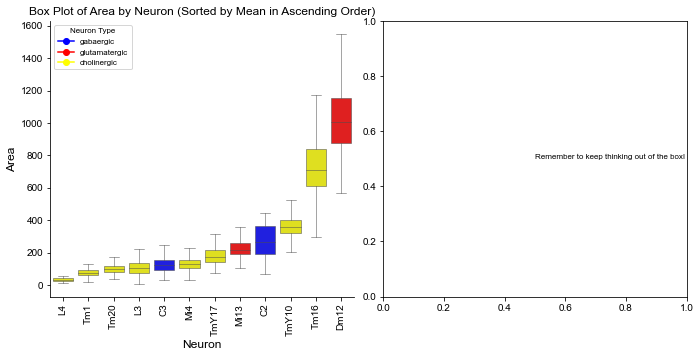

meta NOT subset; don't know how to subset; dropped


FIGURE: All neurons spatial span saved


In [17]:
# Define the neuron categories and their corresponding colors
glutamatergic_neurons = ['Mi13', 'Dm12']  # Choose blue
cholinergic_neurons = ['Tm1', 'Tm20', 'L3', 'L4', 'Mi4', 'TmY17', 'TmY10', 'Tm16']  # Choose green
gabaergic_neurons = ['C2', 'C3']  # Choose red

# Create the neuron_colors and legend_colors dictionaries
neuron_colors = {}
neuron_labels = {}
legend_colors = {}

# Assign colors to glutamatergic neurons and add labels
for neuron in glutamatergic_neurons:
    neuron_colors[neuron] = 'red'
    neuron_labels[neuron] = 'glutamatergic'
    legend_colors['glutamatergic'] = 'red'

# Assign colors to cholinergic neurons and add labels
for neuron in cholinergic_neurons:
    neuron_colors[neuron] = 'yellow'
    neuron_labels[neuron] = 'cholinergic'
    legend_colors['cholinergic'] = 'yellow'

# Assign colors to gabaergic neurons and add labels
for neuron in gabaergic_neurons:
    neuron_colors[neuron] = 'blue'
    neuron_labels[neuron] = 'gabaergic'
    legend_colors['gabaergic'] = 'blue'

# Select the desired columns and assign them to a new DataFrame
selected_columns = ['Area', 'neuron']
selected_df = combined_individual_spatial_span_df[selected_columns]

# Calculate the mean for each neuron category
mean_per_neuron = selected_df.groupby('neuron')['Area'].mean()

# Sort the neuron categories based on mean values in ascending order
sorted_neurons = mean_per_neuron.sort_values(ascending=True).index

# Create a list of colors and labels based on the neuron category of each data point
_palette = [neuron_colors[neuron] for neuron in sorted_neurons]
labels = [neuron_labels[neuron] for neuron in sorted_neurons]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the box plot with sorted order and custom palette in the first subplot
boxplot = sns.boxplot(ax=axs[0], x='neuron', y='Area', data=selected_df, palette=_palette, 
                      order=sorted_neurons,linewidth=0.5,showfliers=False)

# Remove left and top spines
boxplot.spines['right'].set_visible(False)
boxplot.spines['top'].set_visible(False)

# Rotate x-axis tick labels by 90 degrees
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=90)

# Add labels and title to the first subplot
axs[0].set_xlabel('Neuron')
axs[0].set_ylabel('Area')
axs[0].set_title('Box Plot of Area by Neuron (Sorted by Mean in Ascending Order)')

# Add legend with labels and matching colors to the first subplot
legend_labels = list(set(labels))  # Get unique labels
legend_handles = [plt.Line2D([0], [0], marker='o', color=legend_colors[label], markerfacecolor=legend_colors[label], label=label) for label in legend_labels]
axs[0].legend(handles=legend_handles, labels=legend_labels, title='Neuron Type')

# Add the second subplot (you can customize this subplot as needed)
axs[1].text(0.5, 0.5, 'Remember to keep thinking out of the box!')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

if save_figures:    
    figure_title = '\All-neurons-spatial-span-NT.pdf'
    fig.savefig(fig_save_path + figure_title)
    print('FIGURE: All neurons spatial span saved')